# Notes
### 1. variable: eta_t
    default fill value: -32,768
#### (a) time_ytocean_arr\[0] contains missing values <br>
![time_ytocean_arr](images/time_ytocean_arr.png)
#### (b) time_ytocean_arr.data\[0] fills the missing values with default '_FillValue: -32768' <br>
![time_ytocean_arr_data](images/time_ytocean_arr_data.png) <br>
Q: -32768 is too large compare with other values (range between -2 to 0), so what is the resonable value to fill the missing value? mean? median?


In [1]:
import netCDF4 as nc4
import keras
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils


In [4]:
file_path =['C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_01.nc']
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_02.nc')
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_03.nc')
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_04.nc')
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_05.nc')
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_06.nc')

In [6]:
ds = nc4.MFDataset(file_path)
eta_t_arr = ds.variables['eta_t'][:]

In [13]:
ds.variables['eta_t'][:,:,0].shape

(121, 1500)

In [8]:
ds.variables['eta_t']

<class 'netCDF4._netCDF4._Variable'>
int16 eta_t('Time', 'yt_ocean', 'xt_ocean')
    long_name: surface height on T cells [Boussinesq (volume conserving) model]
    units: meter
    valid_range: [-32767  32767]
    missing_value: -32768
    _FillValue: -32768
    packing: 4
    scale_factor: 0.03051851
    add_offset: 0.0
    cell_methods: time: mean
    time_avg_info: average_T1,average_T2,average_DT
    coordinates: geolon_t geolat_t
unlimited dimensions = ('Time',)
current size = (31, 1500, 3600)

In [9]:
eta_t_arr.shape

(31, 1500, 3600)

In [6]:
# raise an OOM error
time_ytocean_xtocean_arr = eta_t_arr.reshape(121,1500*3600)
time_ytocean_xtocean_arr.shape

(121, 5400000)

In [10]:
time_ytocean_arr = eta_t_arr[:,:,0]
time_ytocean_arr.shape

(31, 1500)

In [27]:
time_ytocean_arr = np.divide(time_ytocean_arr, 2)
time_ytocean_arr[0]

masked_array(data=[--, --, --, ..., -0.4119998812675476,
                   -0.4119998812675476, -0.3814813792705536],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [28]:
time_ytocean_arr[0]

masked_array(data=[--, --, --, ..., -0.4119998812675476,
                   -0.4119998812675476, -0.3814813792705536],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [29]:
time_ytocean_arr[0].data

array([ 0.        ,  0.        ,  0.        , ..., -0.41199988,
       -0.41199988, -0.38148138], dtype=float32)

In [13]:
import statistics
statistics.median(time_ytocean_arr[0])

0.06103701889514923

In [30]:
for i in range(0,len(time_ytocean_arr)):
    arr = time_ytocean_arr[i].data
    arr[arr == -32768] = 0


In [31]:
time_ytocean_arr[0].data

array([ 0.        ,  0.        ,  0.        , ..., -0.41199988,
       -0.41199988, -0.38148138], dtype=float32)

In [32]:
# split into train & test
time_ytocean_train, time_ytocean_test = train_test_split(time_ytocean_arr.data, test_size=0.33)
time_ytocean_train.shape

(20, 1500)

In [33]:
input_size = 1500
hidden_size = 150
output_size = 1500

In [34]:
# fit a single layer autoencoder
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='tanh')(x)
r = Dense(output_size, activation='tanh')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1500)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               225150    
_________________________________________________________________
dense_5 (Dense)              (None, 1500)              226500    
Total params: 451,650
Trainable params: 451,650
Non-trainable params: 0
_________________________________________________________________


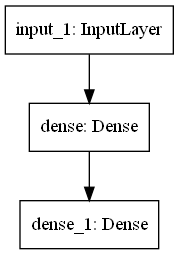

In [19]:
keras.utils.plot_model(autoencoder, "time_ytocean_autoencoder.png")

In [35]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='tanh')(x)
r = Dense(output_size, activation='tanh')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
epochs = 100
batch_size = 1500

history = autoencoder.fit(time_ytocean_train, time_ytocean_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(time_ytocean_test, time_ytocean_test))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1500)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               225150    
_________________________________________________________________
dense_7 (Dense)              (None, 1500)              226500    
Total params: 451,650
Trainable params: 451,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 1s 577ms/step - loss: 0.1527 - val_loss: 0.1243
Epoch 2/100
1/1 [==============================] - 0s 53ms/step - loss: 0.1240 - val_loss: 0.1103
Epoch 3/100
1/1 [==============================] - 0s 54ms/step - loss: 0.1100 - val_loss: 0.0968
Epoch 4/100
1/1 [==============================] - 0s 53ms/step - loss: 0.0966 - val_los

dict_keys(['loss', 'val_loss'])


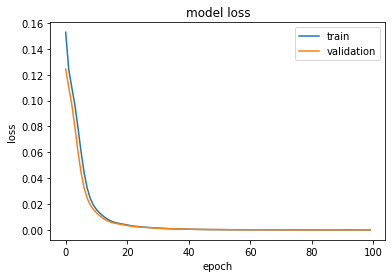

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [37]:
time_ytocean_test_pred = autoencoder.predict(time_ytocean_test)

In [38]:
time_ytocean_test_pred[0]

array([-0.00573234, -0.00317434, -0.01098365, ..., -0.38832137,
       -0.38085032, -0.3651807 ], dtype=float32)

In [39]:
time_ytocean_test[0]

array([ 0.        ,  0.        ,  0.        , ..., -0.41199988,
       -0.41199988, -0.38148138], dtype=float32)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


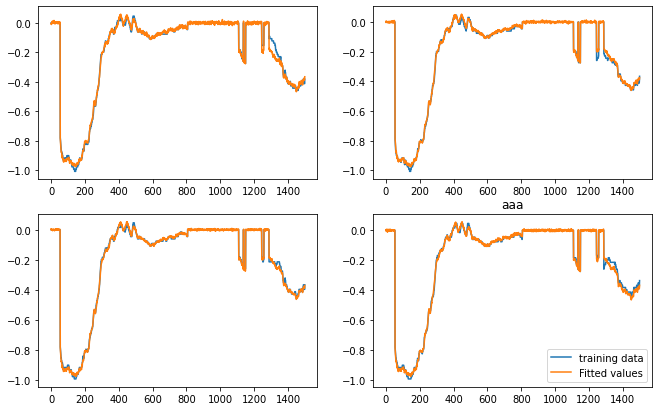

In [67]:
fig, axs = plt.subplots(2, 2,figsize = (11, 7))
axs[0, 0].plot(time_ytocean_test[0], label = 'training data')
axs[0, 0].plot(time_ytocean_test_pred[0], label = 'Fitted values')
plt.legend()
axs[0, 1].plot(time_ytocean_test[1], label = 'training data')
axs[0, 1].plot(time_ytocean_test_pred[1], label = 'Fitted values')
plt.legend()
axs[1, 0].plot(time_ytocean_test[2], label = 'training data')
axs[1, 0].plot(time_ytocean_test_pred[2], label = 'Fitted values')
plt.legend()
axs[1, 1].plot(time_ytocean_test[3], label = 'training data')
axs[1, 1].plot(time_ytocean_test_pred[3], label = 'Fitted values')
plt.title("aaa")
plt.legend()
# axs[0, 0].set_title('Axis [0, 0]')
# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('Axis [0, 1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')


<function matplotlib.pyplot.show(close=None, block=None)>

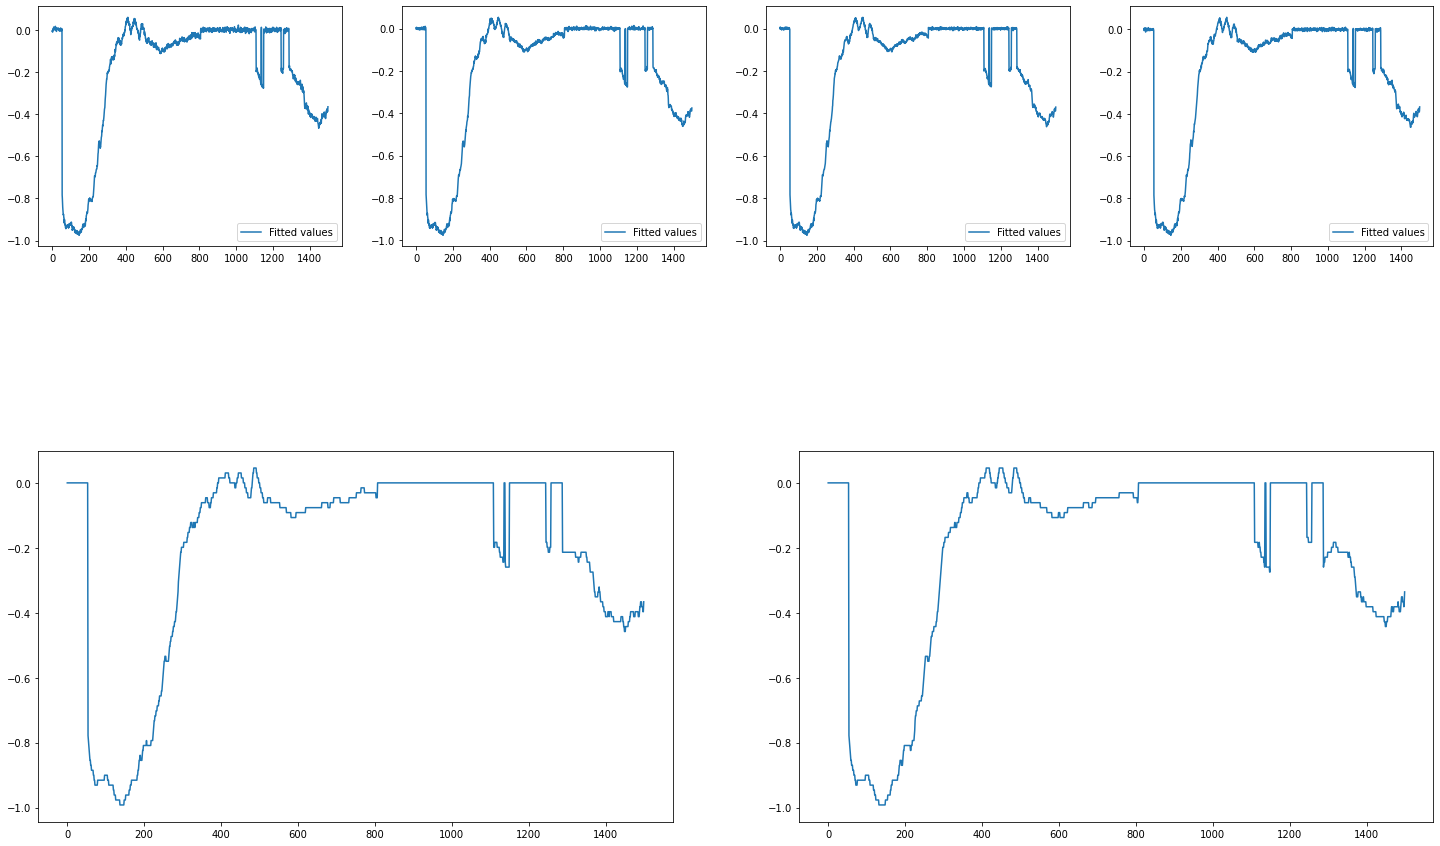

In [58]:
n = 4
plt.figure(figsize=(25, 15))
for i in range(n):
    ax = plt.subplot(2, 2, i+1)
    plt.plot(time_ytocean_test[i], label='training data')
    ax = ax = plt.subplot(3, n, i+1)
    plt.plot(time_ytocean_test_pred[i], label='Fitted values')
    plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

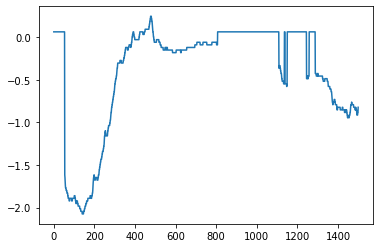

In [33]:
plt.plot(time_ytocean_train[0])
plt.show

# Adding more layers

In [40]:
input_size = 1500
hidden_size = 150
output_size = 1500

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(output_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(output_size, activation='tanh')(hidden_2)

autoencoder_m = Model(inputs=x, outputs=r)
autoencoder_m.compile(optimizer='adam', loss='mse')

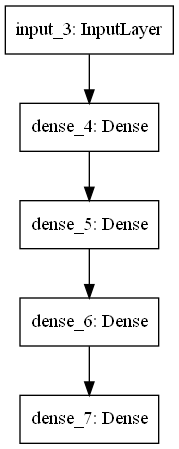

In [30]:
keras.utils.plot_model(autoencoder, "time_ytocean_multilayer_autoencoder.png")

In [41]:
epochs = 100
batch_size = 1500

history_m = autoencoder_m.fit(time_ytocean_train, time_ytocean_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(time_ytocean_test, time_ytocean_test))

Epoch 1/100
1/1 [==============================] - 1s 772ms/step - loss: 0.5510 - val_loss: 0.5171
Epoch 2/100
1/1 [==============================] - 0s 62ms/step - loss: 0.5215 - val_loss: 0.4824
Epoch 3/100
1/1 [==============================] - 0s 65ms/step - loss: 0.4861 - val_loss: 0.4325
Epoch 4/100
1/1 [==============================] - 0s 67ms/step - loss: 0.4351 - val_loss: 0.3823
Epoch 5/100
1/1 [==============================] - 0s 67ms/step - loss: 0.3842 - val_loss: 0.3337
Epoch 6/100
1/1 [==============================] - 0s 65ms/step - loss: 0.3350 - val_loss: 0.2826
Epoch 7/100
1/1 [==============================] - 0s 66ms/step - loss: 0.2834 - val_loss: 0.2361
Epoch 8/100
1/1 [==============================] - 0s 81ms/step - loss: 0.2367 - val_loss: 0.1976
Epoch 9/100
1/1 [==============================] - 0s 63ms/step - loss: 0.1980 - val_loss: 0.1682
Epoch 10/100
1/1 [==============================] - 0s 62ms/step - loss: 0.1685 - val_loss: 0.1476
Epoch 11/100
1/1 [

dict_keys(['loss', 'val_loss'])


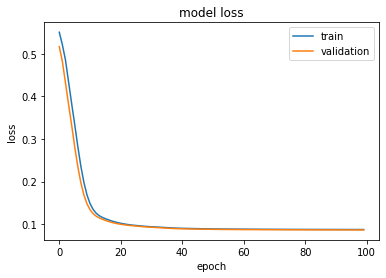

In [42]:
print(history.history.keys())

plt.plot(history_m.history['loss'])
plt.plot(history_m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

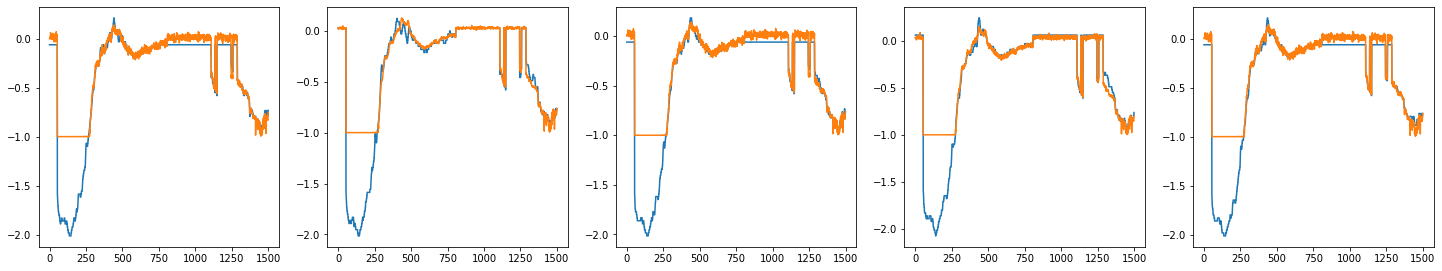

In [43]:
time_ytocean_test_pred_m = autoencoder_m.predict(time_ytocean_test)
n = 5
plt.figure(figsize=(25, 15))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.plot(time_ytocean_test[i])

    ax = ax = plt.subplot(3, n, i+1)
    plt.plot(time_ytocean_test_pred_m[i])
plt.show

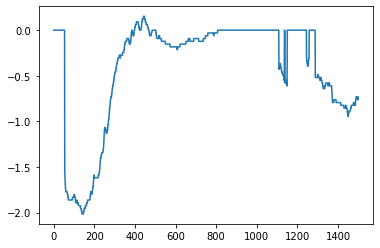

In [24]:
plt.plot(time_ytocean_train[0])